In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import scipy as sp
import coord_transform as coord
import time
from scipy.spatial import distance
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from dask import delayed
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster# this is experimental
from dask_cuda import LocalCUDACluster
from dask.dataframe import from_pandas
import dask.array as da
import dask.bag as db
import cupy as cp
from numba import cuda
from numba import roc
from numba import njit
import numba as nb
import dask
import dask_cudf
import gc
import cupy
import cudf
import os
import time
import math
from multiprocessing import Pool
from itertools import product

In [2]:
df = cudf.read_csv("gaia.csv")

# Reduce data

In [3]:
df = df[4.5 > df["parallax"]/df["parallax_error"]]

# Calculate distance in pc

In [4]:
df["distance_pc"] = 1./df["parallax"]

In [5]:
df = df[df["distance_pc"]>0]

# Converting from spherical to cartesian coordinates

In [6]:
df["x"], df["y"], df["z"] = coord.sph2cart(df["distance_pc"], df["ra"], df["dec"])

In [7]:
df["vx"],df["vy"],df["vz"] = coord.vsph2cart(df["dr2_radial_velocity"], df["pmra"], df["pmdec"], df["distance_pc"], df["ra"], df["dec"])

In [8]:
df = df.drop(df.columns[:13], axis=1)

# Divide set into planets and stars sets. This is only for testing purposes

In [10]:
df["index"] = df.index

In [23]:
planets = df[df["index"] < 175000].to_pandas()

In [24]:
planets

,distance_pc,x,y,z,vx,vy,vz,index
4,4.533882,3.719793,-0.186641,-2.585420,69.817767,-13.857311,-77.070225,4
7,8.251274,6.737695,3.800255,-2.871419,164.664820,53.223959,-84.625623,7
30,2.974852,2.527311,0.167956,-1.560204,5.279663,-4.895415,-28.628855,30
59,13.093292,11.436229,1.327061,-6.235854,45.514479,-33.959848,-114.773070,59
63,51.907321,20.418319,9.380248,-46.791807,-114.175047,-145.084068,-52.722591,63
...,...,...,...,...,...,...,...,...
174672,17.869305,0.437873,-8.620749,-15.646182,-40.882283,98.287504,-6.178595,174672
174681,17.423250,-0.331502,-13.574329,-10.917753,56.718015,106.723114,25.147908,174681
174825,1.389500,-0.292824,-0.309821,-1.322489,-7.098680,-5.022415,-17.711709,174825
174892,13.600626,5.164722,-11.523291,5.051378,-74.321204,-79.899271,33.808291,174892


In [25]:
df = df[df["index"] > 175000]

In [26]:
np_df = df.to_pandas().to_numpy()

### Function creating 2 sets of data.
### Set1 consists of stars within 60pc from target planet. 
### Set2 consists of stars within 80pc from target planet.

In [107]:
@njit
def to_sets(target, i):
    dist1 = 40
    dist2 = 80
    
    set1 = []
    set2 = []
    for j in range(np_df.shape[0]):
        z = np.zeros(shape=target.shape)
        for i in range(len(target)):
            z[i] = target[i] - np_df[j][i+1]
            
        dist = np.sqrt(np.sum(z**2, 0))

        if dist < dist1:
            set1.append([np_df[j][1], np_df[j][2], np_df[j][3], np_df[j][4], np_df[j][5], np_df[j][6]])
        if dist < dist2:
            set2.append([np_df[j][1], np_df[j][2], np_df[j][3], np_df[j][4], np_df[j][5], np_df[j][6]])

    return np.array(set1), np.array(set2)

### For every star in set1 calculate mahalanobis distance to every star in set2. Store only 20 closest stars in an array. Then pick the 20th closest star from the planet 

In [108]:
@njit
def calc_mah(i, set2, set2_inv):

    #mahal_dist = np.zeros(set2.shape[0]-1)
    mahal_dist = np.full(20, 1000, dtype="float64")
    
    for j in range(1, set2.shape[0]):
        set2_inv = np.atleast_2d(set2_inv)
        delta = set2[i] - set2[j]
        m = np.dot(np.dot(delta, set2_inv), delta)

        #mahal_dist[j-1] = np.sqrt(m)
        if np.sqrt(m) < mahal_dist.max():
            mahal_dist[mahal_dist.argmax()] = np.sqrt(m)

    return mahal_dist.max()

### Convert mahalanobis distances of all stars in set1 to density

In [109]:
@njit
def calc_dense(mah_dist_arr):
    density = 20/(mah_dist_arr)**6
    norm_density = density/np.median(density)
    return norm_density

### Use density to create GausianMixture model and draw low and high density groups

In [110]:
def draw(norm_density):
    # Add second dimension and transpose array to match input format for GaussianMixture
    X = np.expand_dims(np.log10(norm_density), axis=0).T

    # train GaussianMixture
    model = GaussianMixture(2).fit(X)

    # Define figure params
    fig = plt.figure(figsize=(50, 5))
    fig.subplots_adjust(left=0.12, right=0.97, bottom=0.21, top=0.9, wspace=0.5)
    ax = fig.add_subplot(131)

    x = np.linspace(-6, 6, 1000)
    logprob = model.score_samples(x.reshape(-1, 1))
    responsibilities = model.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
    # Add combined kde line
    ax.plot(x, pdf, '-k')
    # Add individual lines for low and high density
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "Best-fit Mixture", ha='left', va='top', transform=ax.transAxes)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    plt.savefig("plot_v1.png", bbox_inches='tight')
    plt.show()
    #print(X.mean())
    #print(model.means_)

### Loop through all planets and apply above functions. 
### For testing purposes I am using only 3 planets and 1000 stars from set1. This takes around 90 seconds on my PC to compute. At the moment for planet with 150000 neighbours within 40pc it would take around 1 hour and 10 minutes to compute.

In [120]:
def get_stars():

    o=0
    density_list = []

    for i, row in planets.iterrows():
        
        if o == 3:
            break
        target = np.array([row[1], row[2], row[3]])
        set1, set2 = to_sets(target, i)
        

        set2_cov_mat = np.cov(set2.T) # Calculate the covariance matrix
        set2_inv = np.linalg.inv(set2_cov_mat)
        
        mah_dist_arr = np.zeros(1000)
        for j in range(set1.shape[0]):
            if j == 1000:
                break
            mah_dist_arr[j] = (calc_mah(j, set1, set2_inv))

        norm_density = calc_dense(np.array(mah_dist_arr))
        density_list.append(norm_density)

        draw(norm_density)
        o = o + 1
    return density_list

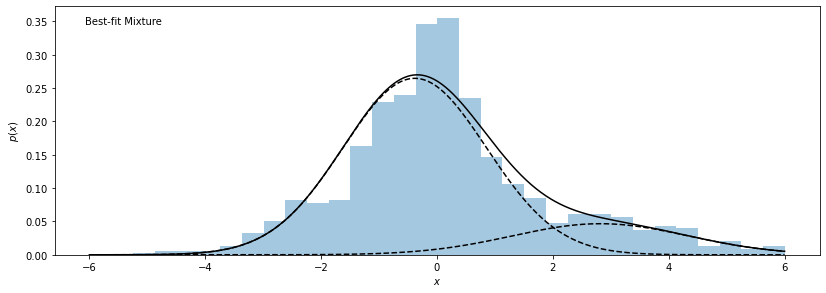

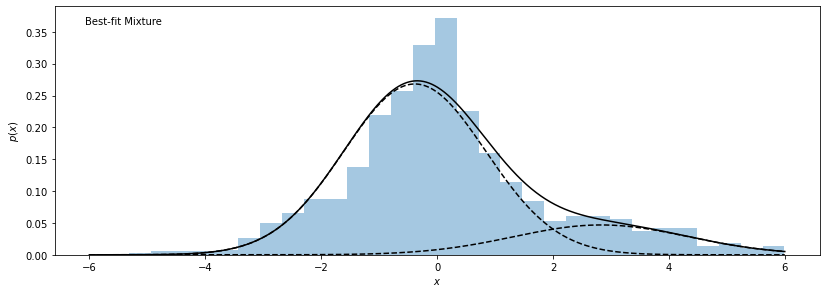

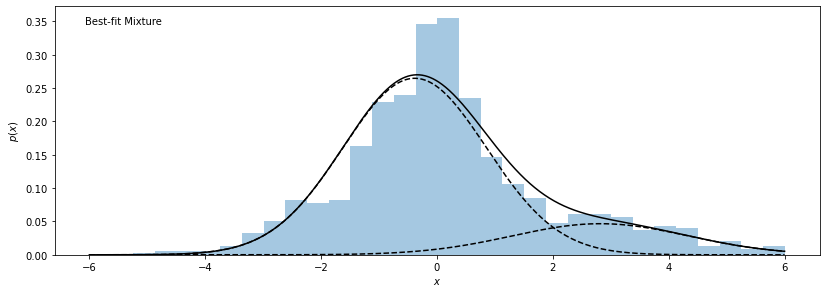

84.76944116199957

In [121]:
start = time.perf_counter()
norm_density = get_stars()
end = time.perf_counter()
end-start